# Attempt to  process a CPN dataset containing 10 different sounds

In [1]:
from src.metrics.significance import _significance, _mask_with_significance
from src.metrics.consolidated_dprimes import _load_site_formated_raster,  single_cell_dprimes, probewise_LDA_dprimes, probewise_dPCA_dprimes, full_dPCA_dprimes
from src.metrics.dprime import flip_dprimes
from src.data.load import get_site_ids, set_name
from src.metrics.consolidated_metrics import metrics_to_DF, _append_means_to_array, _append_means_to_shuff_array
from src.data.region_map import region_map

import itertools as itt
import numpy as np
import pandas as pd
from configparser import ConfigParser
import pathlib as pl
from joblib import dump, load, Parallel, delayed
from src.root_path import root_path,config_path
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.fancy_plots import _raster, unit_line, savefig
from src.data.dPCA import _cpp_dPCA, format_raster

from IPython.display import display

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-09-08 163015.log
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}


importing region_map: site ley058d has undefined region


In [2]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [3]:
#general plottin formating
plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])

[matplotlib WARNING] Bad value in file PosixPath('/home/mateo/code/context_probe_analysis/config/notebook.mplstyle'), line 12 ('svg.fonttype : None'): Key svg.fonttype: 'None' is not a valid value for svg.fonttype; supported values are ['none', 'path']
[matplotlib WARNING] 
Bad key font.sans-serif' in file /home/mateo/code/context_probe_analysis/config/notebook.mplstyle, line 13 ("font.sans-serif': Arial")
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# rec_recache = False
# dprime_recache = False

alpha=0.05

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

expt = {'contexts': list(range(11)),
        'probes': list(range(1,11))}



## example site loaded

In [5]:
example_site = 'TNC018a'
dprime, shuffled_dprime, goodcells, var_capt = full_dPCA_dprimes(example_site, **expt, meta=meta)

print(f'dprime: {dprime.shape}')


dprime: (1, 55, 10, 30)


## run all sites
parallelized and chached

In [6]:
# run in parallel all 10sound sites, this will take a while
siteids = ['TNC013a', 'TNC014a', 'TNC015a', 'TNC016a', 'TNC017a', 'TNC018a']

_ = Parallel(n_jobs=4)(delayed(full_dPCA_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('full dPCA done')

full dPCA done


In [7]:
_ = Parallel(n_jobs=4)(delayed(probewise_dPCA_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('probewise dPCA done')

probewise dPCA done


In [8]:
# fails due to RAM liminations

_ = Parallel(n_jobs=4)(delayed(single_cell_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('signle cell done')

signle cell done


In [9]:
def load_all_raw_data(id, fulldpca=True):

    # def analysis_steps_plot(id, probe):
    site = id[:7]
    if len(id) == 7:
        population = True
    else:
        population = False

    # loads the raw data
    raster, goodcells = _load_site_formated_raster(site, **expt, meta=meta)
    trialR, R, _ = format_raster(raster)

    if population and fulldpca:
        _, trialZ, dpca = _cpp_dPCA(R, trialR)
        trialR = trialZ['ct'][:, 0, ...][:,None,...]
        dprime, shuff_dprime_quantiles, goodcells, dPCA = full_dPCA_dprimes(site, **expt, meta=meta)

    elif population and not fulldpca:
        r, n, c, p, t = trialR.shape
        trialZ = np.empty((r, 1, c, p, t))
        for probe_idx in range(p):
            probe_trialR = trialR[..., probe_idx, :]
            probe_R = R[..., probe_idx, :]

            # calculates dPCA considering all 4 categories
            _, probe_trialZ, _ = _cpp_dPCA(probe_R, probe_trialR)
            trialZ[:, :, :, probe_idx, :] = probe_trialZ['ct'][:, 0, ...][:,None,...]

        trialR = trialZ
        dprime, shuff_dprime_quantiles, goodcells, dPCA = probewise_dPCA_dprimes(site, **expt, meta=meta)

    else:
        dprime, shuff_dprime_quantiles, goodcells, dPCA = single_cell_dprimes(site, **expt, meta=meta)


    dprime, flipped_quantils = flip_dprimes(dprime, shuff_dprime_quantiles, flip='sum')
    significance, confidence_interval = _significance(dprime, flipped_quantils, [3], 3, alpha=alpha)

    t =  np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                            endpoint=False) * 1000

    return trialR, dprime, flipped_quantils, significance, confidence_interval, goodcells, t



In [10]:
def single_psth(trialR, cell_idx, trans_idx, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx, probe_idx, :].mean(axis=0), color=f'C{trans_idx}',
                     linewidth=3)
    return ax

def single_raster(trialR, cell_idx, trans_idx, probe_idx, ax):
    # plot raster only for single cells
    _ = _raster(t, trialR[:, cell_idx, trans_idx, probe_idx, :], y_offset=0, y_range=ax.get_ylim(), ax=ax,
                         scatter_kws={'color': f'C{trans_idx}', 'alpha': 0.4, 's': 10})
    return ax

# Paired PSTHs on the upper triangle
def double_psth(trialR, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx_0, probe_idx, :].mean(axis=0), color=f'C{trans_idx_0}',
                     linewidth=3)

    ax.plot(t, trialR[:, cell_idx, trans_idx_1, probe_idx, :].mean(axis=0), color=f'C{trans_idx_1}',
                     linewidth=3)
    return ax

# dprime plus CI on the lower triangle
def dprime_ci(dprime, confidence_interval, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')
    ax.plot(t, dprime[cell_idx, trans_pair_idx, probe_idx, :], color='white')
    ax.fill_between(t, confidence_interval[0, cell_idx, trans_pair_idx, probe_idx, :],
                    confidence_interval[1, cell_idx, trans_pair_idx, probe_idx, :],
                    color='white', alpha=0.5)
    return ax

# iterates over the grid
def grid_plot(id, trialR, dprime, confidence_interval, probe):

    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)

    fig = plt.figure(figsize=(8,8))

    n_ctx = trialR.shape[2] # Reps x Neurons x Contexts x Probex x TimePoints
    gs = fig.add_gridspec(n_ctx,n_ctx)

    first_up = True
    first_lo = True

    diagonals = list()
    for x, y in itt.product(range(n_ctx),range(n_ctx)):

        # creates subplots with shared x axis for the diagonal and upper triangle
        if x <= y:
            if first_up:
                upax = fig.add_subplot(gs[x,y])
                ax = upax
                first_up = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=upax)
        else:
            if first_lo:
                loax = fig.add_subplot(gs[x,y])
                ax = loax
                first_lo = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=loax)

        # plots upper triangle psth
        if x < y:
            _ = double_psth(trialR, cell_idx, x, y, probe_idx, ax)


        #plots lower triangle dprime
        elif x > y:
            _ = dprime_ci(dprime, confidence_interval, cell_idx, y, x, probe_idx, ax)

        # plots diagonal raster
        else:
            _ = single_psth(trialR, cell_idx, x, probe_idx, ax)
            diagonals.append(ax)

        # removes time tick labels
        if x != n_ctx-1:
            plt.setp(ax.get_xticklabels(), visible=False)

        # add time labels
        else:
            if y == int(n_ctx/2):
                ax.set_xlabel('time (ms)')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # removes y tick lables
        if y not in [0,n_ctx-1]:
            plt.setp(ax.get_yticklabels(), visible=False)

        # remove y labels on the first psth
        if y == 0 and x == 0:
            plt.setp(ax.get_yticklabels(), visible=False)

        # dprime labels on left side
        if y == 0 and x == int(n_ctx/2):
            ax.set_ylabel("contextual effects discriminability (d')")

        # zscore firing rate ticks on right side
        if y == n_ctx-1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            if x == int(n_ctx/2):
                ax.set_ylabel('firing rate (z-score)')
            ax.spines['right'].set_visible(True)

    if len(id)>7:
        for n, ax in enumerate(diagonals):
            _ =single_raster(trialR, cell_idx, n, probe_idx, ax)
    else:
        for n, ax in enumerate(diagonals):
            ax.axhline(0, color='white', linestyle='--')

    return fig


## probewise dPCA example for best site and probe

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC018a_38a8c51bbfde8def275064f479df65378df73507.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.evp


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.006640873038344959
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.
You chose to determine the regularization parameter

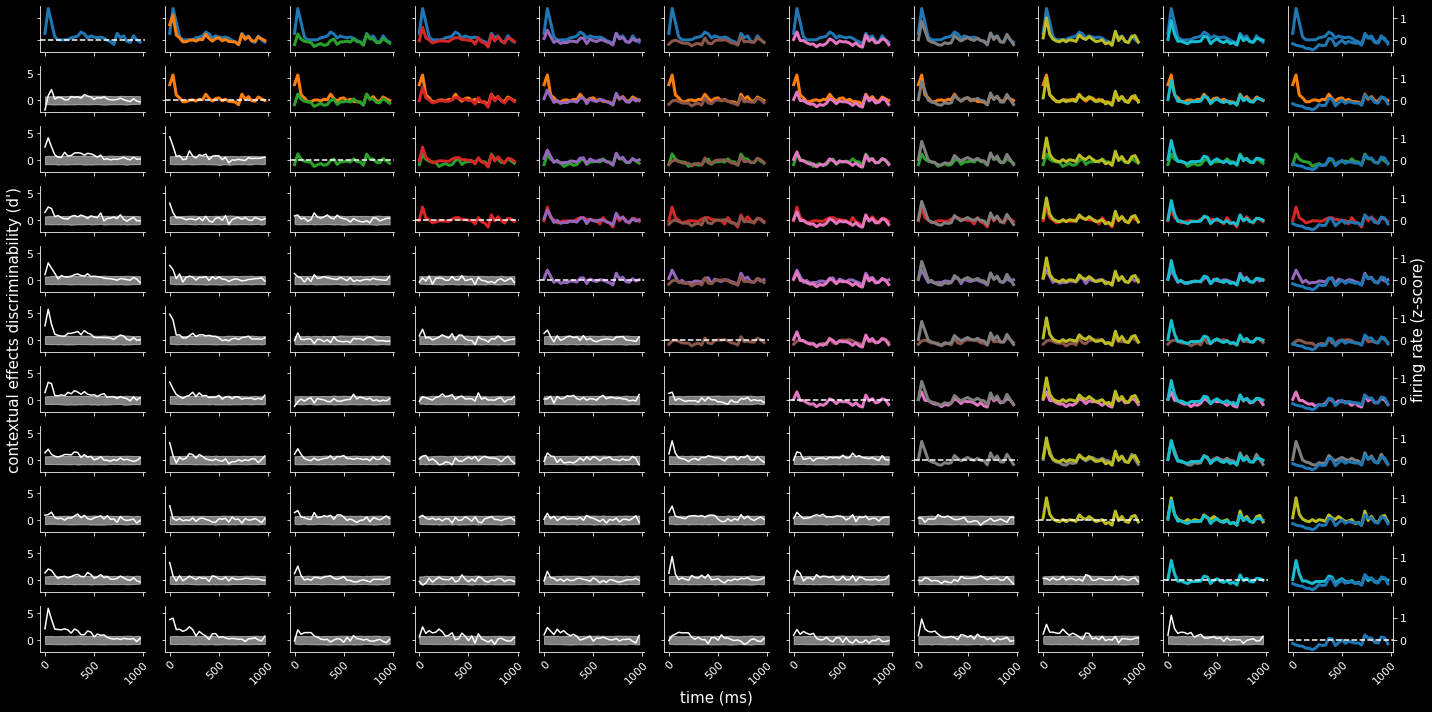

In [11]:
trialR, dprime, shuffled_dprime_quantiles, significance, confidence_interval, goodcells, t = load_all_raw_data(example_site, fulldpca=False)
fig = grid_plot(example_site, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_site}'

## full dPCA example for best site and probe

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC018a_38a8c51bbfde8def275064f479df65378df73507.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.evp


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.0017286737396774677
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


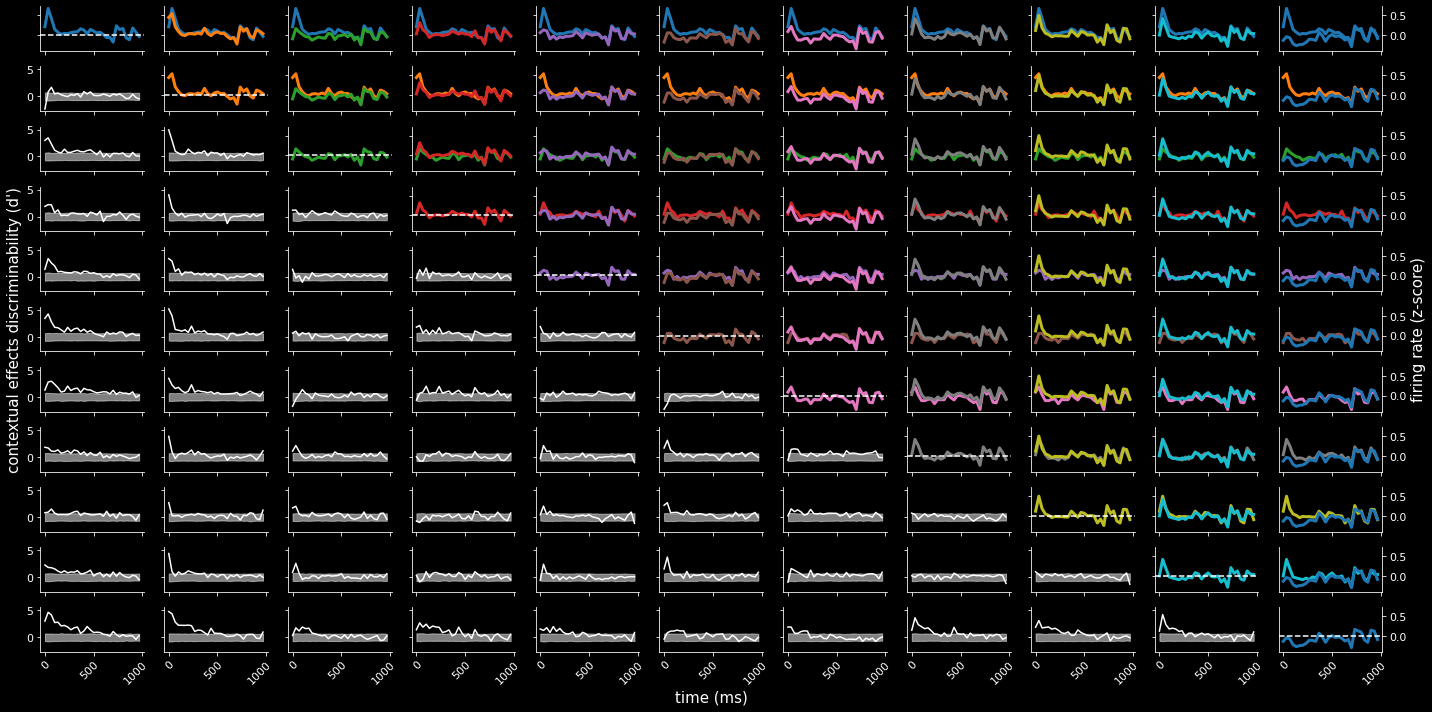

In [12]:
trialR, dprime, shuffled_dprime_quantiles, significance, confidence_interval, goodcells, t = load_all_raw_data(example_site, fulldpca=True)
fig = grid_plot(example_site, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_site}'


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC014a_5974a372fdafb20c8baaab7ef3c1f6ed78ba582e.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.evp


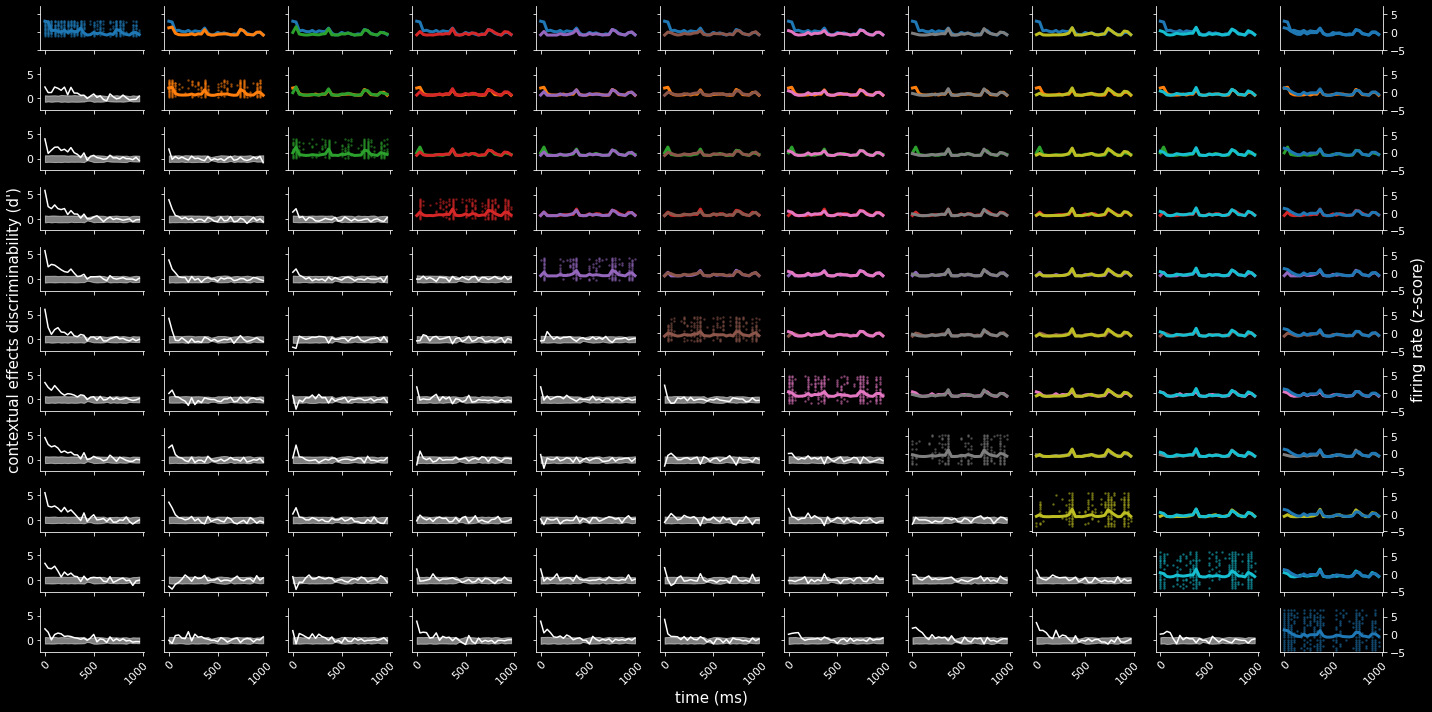

In [13]:
example_cell = 'TNC014a-22-1'
trialR, dprime, shuffled_dprime_quantiles, significance, confidence_interval, goodcells, t = load_all_raw_data(example_cell, fulldpca=True)
fig = grid_plot(example_cell, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_cell}'

In [14]:
trialR.shape

(20, 44, 11, 10, 30)

# Analysiss over calculated metrics

In [131]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'210902_consolidated_summary_DF_alpha_{alpha}' / set_name(meta)
DF = load(summary_DF_file)


In [133]:
def format_dataframe(DF):
    ff_probe = DF.probe != 'mean'
    ff_pairs = DF.context_pair != 'mean'
    try:
        ff_mean = DF.mean_signif_type == 'shuffles'
    except:
        print('no mean_signif_type, taking all values')
        ff_mean = pd.Series(np.full(DF.shape[0], True))


    try:
        ff_stim = DF.stim_type == 'permutations'
    except:
        print('no stim_type, taking all values')
        ff_stim = pd.Series(np.full(DF.shape[0], True))


    ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
    ff_corr = DF.mult_comp_corr == 'consecutive_3'
    ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_sum'])

    good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
                'probe', 'metric', 'value']
    filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

    # rename metrics and analysis for ease of ploting
    filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                     'significant_abs_mean': "mean d'",
                                                     'significant_abs_sum': "integral (d'*ms)"})
    filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                         'fdPCA': 'population',
                                                         'pdPCA': 'probewise pop',
                                                         'LDA': 'pop ceiling'})

    filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
    filtered = filtered.drop(columns=['cellid', 'siteid'])

    filtered['value'] = filtered['value'].fillna(value=0)

    # permutation related preprocesing.
    # creates a new column relating probe with  context pairs
    ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
    prb = np.asarray(filtered.probe, dtype=int)

    silence = ctx == 0
    same = ctx == prb[:,None]
    different = np.logical_and(~silence, ~same)

    name_arr = np.full_like(ctx, np.nan, dtype=object)
    name_arr[silence] = 'silence'
    name_arr[same] = 'same'
    name_arr[different] = 'diff'
    comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

    # swaps clasification names to not have repetitions i.e. diff_same == same_diff
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
    comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
    comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

    filtered['trans_pair'] = comp_name_arr

    ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
    pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
    pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

    full_long = filtered # saves long format for subsamplig analysis

    return pivoted, full_long



pivoted, full_long = format_dataframe(DF)

no mean_signif_type, taking all values
no stim_type, taking all values


In [90]:
def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

def nonan_proportion(arr):
    return np.sum(~np.isnan(arr))/arr.size * 100

def nozero_percentage(arr):
    return np.sum(arr>0) / np.size(arr) * 100

def nozero_proportion(arr):
    return np.sum(arr>0) / np.size(arr)

# systematic subsampling of contexts and probes

Iterates over each contexts or probe subsampling, considering all possible combinations for each subsampling.
Counts the number definese the number of sigificant isntances. then storese in a dataframe with specific subsamples as
indices.

In [18]:
display(pivoted)

metric,analysis,region,id,context_pair,trans_pair,probe,center of mass (ms),integral (d'*ms)
0,population,A1,TNC013a,00_01,silence_diff,2,483.735883,664.734197
1,population,A1,TNC013a,00_01,silence_diff,3,651.800868,256.015239
2,population,A1,TNC013a,00_01,silence_diff,4,466.272493,114.467315
3,population,A1,TNC013a,00_01,silence_diff,5,0.000000,0.000000
4,population,A1,TNC013a,00_01,silence_diff,6,163.160211,91.456591
...,...,...,...,...,...,...,...,...
139145,single cell,A1,TNC018a-54-1,09_10,diff_diff,6,0.000000,0.000000
139146,single cell,A1,TNC018a-54-1,09_10,diff_diff,7,0.000000,0.000000
139147,single cell,A1,TNC018a-54-1,09_10,diff_diff,8,0.000000,0.000000
139148,single cell,A1,TNC018a-54-1,09_10,same_diff,9,0.000000,0.000000


In [19]:
# filteres dataframe and adds required columns
filtered = pivoted.loc[pivoted.analysis=='single cell', :]
filtered['site'] = filtered.id.apply(lambda x: x[:7])

ctx_pairs = [pair.split('_') for pair in filtered.context_pair]
ctx_pairs = np.stack(ctx_pairs, axis=0)
filtered['ctx_0'] = ctx_pairs[:, 0]
filtered['ctx_1'] = ctx_pairs[:, 1]

# function to aggregate each single cell. gives the proportion of significant instances
agg_funcs = {"signif_proportion": ("integral (d'*ms)", nozero_percentage)}


<ipython-input-19-7bfa8e7a0465>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['site'] = filtered.id.apply(lambda x: x[:7])
<ipython-input-19-7bfa8e7a0465>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ctx_0'] = ctx_pairs[:, 0]
<ipython-input-19-7bfa8e7a0465>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [20]:
# iterates over all sizes of probe subsampling, i.e. 1, 2, 3 and 4 probes.
prb_subsampling_path = pl.Path(config['paths']['analysis_cache']) / '210831_prb_subsampling_DF'
recache_prb = False
if (not prb_subsampling_path.exists())  or recache_prb:
    print(f'creating prb_subsamp_signif dataframe')
    all_probes = filtered.probe.sort_values().unique()
    prb_subsamp_signif = pd.DataFrame()

    for num_probe in range(len(all_probes)):
        num_probe += 1

        n_probe_groups  = list(itt.combinations(all_probes, num_probe))
        # iterates over all possible combinations of n probes
        for pg, probe_group in enumerate(n_probe_groups):
            probe_group = [int(p) for p in probe_group]
            probes_df = filtered.loc[filtered.probe.isin(probe_group), :].set_index('region', 'site', 'id')
            grouped  = probes_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
            grouped.loc[grouped.signif_proportion == 0] = np.nan
            grouped['n_probes'] = num_probe
            grouped['prb_group'] = '_'.join([str(p) for p in probe_group])
            prb_subsamp_signif = prb_subsamp_signif.append(grouped.reset_index())


    dump(prb_subsamp_signif, prb_subsampling_path)
    print(f'prb_subsamp_signif chached at {prb_subsampling_path}')

else:
    print(f'loading prb_subsamp_signif from {prb_subsampling_path}')
    prb_subsamp_signif = load(prb_subsampling_path)

display(prb_subsamp_signif)

loading prb_subsamp_signif from /home/mateo/code/context_probe_analysis/data/210831_prb_subsampling_DF


,region,site,id,signif_proportion,n_probes,prb_group
0,A1,TNC013a,TNC013a-03-1,1.818182,1,1
1,A1,TNC013a,TNC013a-03-3,3.636364,1,1
2,A1,TNC013a,TNC013a-07-1,NaN,1,1
3,A1,TNC013a,TNC013a-10-1,NaN,1,1
4,A1,TNC013a,TNC013a-11-1,NaN,1,1
...,...,...,...,...,...,...
242,A1,TNC018a,TNC018a-43-1,8.363636,10,1_2_3_4_5_6_7_8_9_10
243,A1,TNC018a,TNC018a-46-1,14.181818,10,1_2_3_4_5_6_7_8_9_10
244,A1,TNC018a,TNC018a-48-1,10.000000,10,1_2_3_4_5_6_7_8_9_10
245,A1,TNC018a,TNC018a-50-1,5.272727,10,1_2_3_4_5_6_7_8_9_10


In [21]:
# iterates over all sizes of context subsampling, i.e. 2, 3, 4 and 5 contexts.
ctx_subsampling_path = pl.Path(config['paths']['analysis_cache']) / '210831_ctx_subsampling_DF'
recache_ctx = False
if (not ctx_subsampling_path.exists()) or recache_ctx:

    all_contexts = np.unique(ctx_pairs)
    ctx_subsamp_signif = pd.DataFrame()

    for num_ctx in range(2, len(all_contexts)+1):
        n_ctx_groups  = list(itt.combinations(all_contexts, num_ctx))
        # iterates over all possible combinations of n probes
        for cg, ctx_group in enumerate(n_ctx_groups):
            ctx_df = filtered.loc[(filtered.ctx_0.isin(ctx_group)) &
                                     ((filtered.ctx_1.isin(ctx_group))), :].set_index('region', 'site', 'id')
            grouped  = ctx_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
            grouped.loc[grouped.signif_proportion == 0] = np.nan
            grouped['n_contexts'] = num_ctx
            grouped['ctx_group'] = '_'.join(ctx_group)
            ctx_subsamp_signif = ctx_subsamp_signif.append(grouped.reset_index())

    dump(ctx_subsamp_signif, ctx_subsampling_path)
    print(f'ctx_subsamp_signif chached at {ctx_subsampling_path}')
else:
    print(f'loading ctx_subsamp_signif from {ctx_subsampling_path}')
    ctx_subsamp_signif = load(ctx_subsampling_path)

display(ctx_subsampling_path)

loading ctx_subsamp_signif from /home/mateo/code/context_probe_analysis/data/210831_ctx_subsampling_DF


PosixPath('/home/mateo/code/context_probe_analysis/data/210831_ctx_subsampling_DF')

## Proportion of significant instances for individual cells
only looking at cells with at least one significant instance

In [108]:
display(ctx_subsamp_signif)

,region,site,id,signif_proportion,n_contexts,ctx_group
0,A1,TNC013a,TNC013a-03-1,NaN,2,00_01
1,A1,TNC013a,TNC013a-03-3,NaN,2,00_01
2,A1,TNC013a,TNC013a-07-1,10.000000,2,00_01
3,A1,TNC013a,TNC013a-10-1,NaN,2,00_01
4,A1,TNC013a,TNC013a-11-1,NaN,2,00_01
...,...,...,...,...,...,...
242,A1,TNC018a,TNC018a-43-1,8.363636,11,00_01_02_03_04_05_06_07_08_09_10
243,A1,TNC018a,TNC018a-46-1,14.181818,11,00_01_02_03_04_05_06_07_08_09_10
244,A1,TNC018a,TNC018a-48-1,10.000000,11,00_01_02_03_04_05_06_07_08_09_10
245,A1,TNC018a,TNC018a-50-1,5.272727,11,00_01_02_03_04_05_06_07_08_09_10


Text(0.5, 0.98, 'Proportion of significant instances\nfor individual cells')

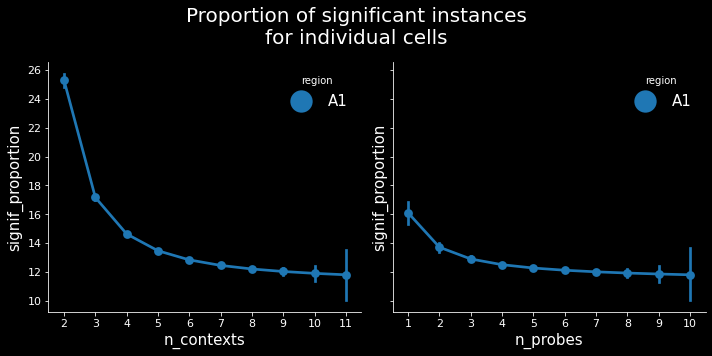

In [22]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signif_proportion', data=ctx_subsamp_signif, hue='region', dodge=True, ax=ctx_ax)
_ = sns.pointplot(x='n_probes', y='signif_proportion', data=prb_subsamp_signif, hue='region', dodge=True, ax=prb_ax)

fig.suptitle('Proportion of significant instances\nfor individual cells', fontsize=20)

## count of significant cells by site and or region

In [23]:
# collapses across neurons. Keeps information about region and ctx / prb subsamples.

ctx_count_by_site = ctx_subsamp_signif.set_index(['region','site', 'n_contexts','ctx_group']
                                     ).groupby(['region', 'site', 'n_contexts','ctx_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()

prb_count_by_site = prb_subsamp_signif.set_index(['region','site', 'n_probes','prb_group']
                                     ).groupby(['region', 'site', 'n_probes','prb_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()

saving at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/proportion of significantly modulated neurons pers site.png


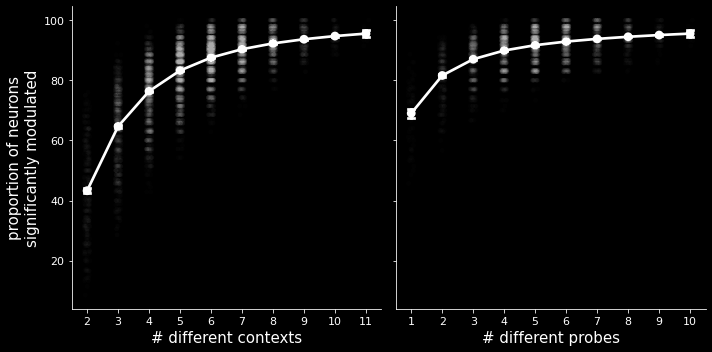

In [46]:
# hue='region'
color = 'white'

fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signfi_cell_prop', color=color, data=ctx_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=ctx_ax,)
_ = sns.stripplot(x='n_contexts', y='signfi_cell_prop', color=color, data=ctx_count_by_site,
                  dodge=True, alpha=0.01, ax=ctx_ax)
ctx_ax.legend([],[], frameon=False)
ctx_ax.set_xlabel('# different contexts')
ctx_ax.set_ylabel('proportion of neurons\nsignificantly modulated')


_ = sns.pointplot(x='n_probes', y='signfi_cell_prop', color=color, data=prb_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=prb_ax)
_ = sns.stripplot(x='n_probes', y='signfi_cell_prop', color=color, data=prb_count_by_site,
                  dodge=True, alpha=0.01, ax=prb_ax)
prb_ax.legend([],[], frameon=False)
prb_ax.set_xlabel('# different probes')
prb_ax.set_ylabel('')

title = 'proportion of significantly modulated neurons pers site'

savefig(fig, 'NGP_retreat', title)

# Histograms
 of number of neurons responsive to different number of contexts-pairs, probes or context-pair-probes

In [25]:
agg_funcs = {"integration instance proportion": ("integral (d'*ms)", nozero_proportion)}

ctx_prb_count = pivoted.set_index(['analysis', 'region', 'id']
                              ).groupby(['analysis', 'region', 'id']
                              ).agg(**agg_funcs).reset_index()

metric,analysis,region,id,context_pair,trans_pair,probe,center of mass (ms),integral (d'*ms)
0,population,A1,TNC013a,00_01,silence_diff,2,483.735883,664.734197
1,population,A1,TNC013a,00_01,silence_diff,3,651.800868,256.015239
2,population,A1,TNC013a,00_01,silence_diff,4,466.272493,114.467315
3,population,A1,TNC013a,00_01,silence_diff,5,0.000000,0.000000
4,population,A1,TNC013a,00_01,silence_diff,6,163.160211,91.456591
...,...,...,...,...,...,...,...,...
139145,single cell,A1,TNC018a-54-1,09_10,diff_diff,6,0.000000,0.000000
139146,single cell,A1,TNC018a-54-1,09_10,diff_diff,7,0.000000,0.000000
139147,single cell,A1,TNC018a-54-1,09_10,diff_diff,8,0.000000,0.000000
139148,single cell,A1,TNC018a-54-1,09_10,same_diff,9,0.000000,0.000000


### sigle neuron

saving at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/modulated neurons histogram 10 sounds.png


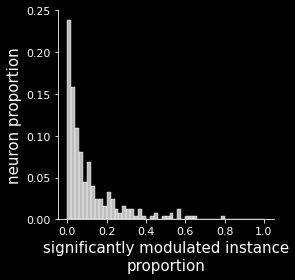

In [129]:
fig, ax = plt.subplots()
# ax.set_title('context-pair probe\ninstances')

hist_data = ctx_prb_count.loc[ctx_prb_count.analysis =='single cell', :]
_ = sns.histplot(data=hist_data,x='integration instance proportion', ax=ax, color='white', stat='probability',
                 bins=50, binrange=[0,1], common_norm=False)
ax.set_xlabel('significantly modulated instance\nproportion')
ax.set_ylabel('neuron proportion')

title = f'modulated neurons histogram 10 sounds'
savefig(fig, 'NGP_retreat', title)

### population

saving at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/modulated site histogram 10 sounds.png


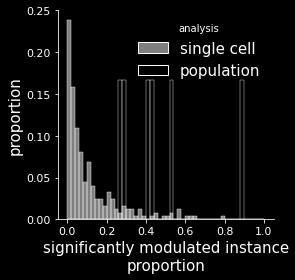

In [130]:
fig, ax = plt.subplots()
# ax.set_title('context-pair probe\ninstances')
hist_data = ctx_prb_count
out = sns.histplot(data=hist_data,x='integration instance proportion', ax=ax, hue='analysis',
                 hue_order=['single cell', 'population'], palette=['white','black'], stat='probability',
                 bins=50, binrange=[0,1], common_norm=False)
ax.set_xlabel('significantly modulated instance\nproportion')
ax.set_ylabel('proportion')

title = f'modulated site histogram 10 sounds'
savefig(fig, 'NGP_retreat', title)

# neuron (or PC) fingerprint
it displays all probes on the y axis and combinations of context-pairs on the x axis

In [29]:

pivot_ready = full_long.loc[full_long.analysis == 'single cell',
                            ['region', 'id', 'context_pair', 'probe', 'metric', 'value']]
pivot_ready['site'] = pivot_ready.id.apply(lambda x: x[:7])


summary = pivot_ready.pivot_table(values='value', index=['region', 'site', 'id', 'probe'],
                                  columns=['metric', 'context_pair'], fill_value=np.nan)

summary.index = summary.index.droplevel([0, 1])
display(summary)

metric             center of mass (ms)                                      \
context_pair                     00_01 00_02       00_03       00_04 00_05   
id           probe                                                           
TNC013a-03-1 1                     0.0   0.0    0.000000    0.000000   0.0   
             2                     0.0   0.0    0.000000    0.000000   0.0   
             3                     0.0   0.0  665.471044  632.055818   0.0   
             4                     0.0   0.0    0.000000    0.000000   0.0   
             5                     0.0   0.0    0.000000    0.000000   0.0   
...                                ...   ...         ...         ...   ...   
TNC018a-54-1 6                     0.0   0.0    0.000000    0.000000   0.0   
             7                     0.0   0.0    0.000000    0.000000   0.0   
             8                     0.0   0.0    0.000000    0.000000   0.0   
             9                     0.0   0.0    0.000000    0.000000   0.0   
             10                    0.0   0.0    0.000000    0.000000   0.0   

metric                                                 ... integral (d'*ms)  \
context_pair       00_06 00_07      00_08 00_09 00_10  ...            06_07   
id           probe                                     ...                    
TNC013a-03-1 1       0.0   0.0   0.000000   0.0   0.0  ...         0.000000   
             2       0.0   0.0   0.000000   0.0   0.0  ...         0.000000   
             3       0.0   0.0   0.000000   0.0   0.0  ...        68.586058   
             4       0.0   0.0  64.801788   0.0   0.0  ...         0.000000   
             5       0.0   0.0   0.000000   0.0   0.0  ...         0.000000   
...                  ...   ...        ...   ...   ...  ...              ...   
TNC018a-54-1 6       0.0   0.0   0.000000   0.0   0.0  ...         0.000000   
             7       0.0   0.0   0.000000   0.0   0.0  ...         0.000000   
             8       0.0   0.0   0.000000   0.0   0.0  ...         0.000000   
             9       0.0   0.0   0.000000   0.0   0.0  ...         0.000000   
             10      0.0   0.0   0.000000   0.0   0.0  ...         0.000000   

metric                                                                       \
context_pair       06_08 06_09      06_10      07_08 07_09 07_10      08_09   
id           probe                                                            
TNC013a-03-1 1       0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   
             2       0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   
             3       0.0   0.0   0.000000  83.255621   0.0   0.0  65.506164   
             4       0.0   0.0  60.125469   0.000000   0.0   0.0   0.000000   
             5       0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   
...                  ...   ...        ...        ...   ...   ...        ...   
TNC018a-54-1 6       0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   
             7       0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   
             8       0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   
             9       0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   
             10      0.0   0.0   0.000000   0.000000   0.0   0.0   0.000000   

metric                               
context_pair            08_10 09_10  
id           probe                   
TNC013a-03-1 1       0.000000   0.0  
             2       0.000000   0.0  
             3      85.039908   0.0  
             4       0.000000   0.0  
             5       0.000000   0.0  
...                       ...   ...  
TNC018a-54-1 6       0.000000   0.0  
             7       0.000000   0.0  
             8       0.000000   0.0  
             9       0.000000   0.0  
             10      0.000000   0.0  

[2470 rows x 110 columns]

saving at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/TNC014a-22-1 integral (d'*ms) barcode.png
saving at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/TNC014a-22-1 center of mass (ms) barcode.png


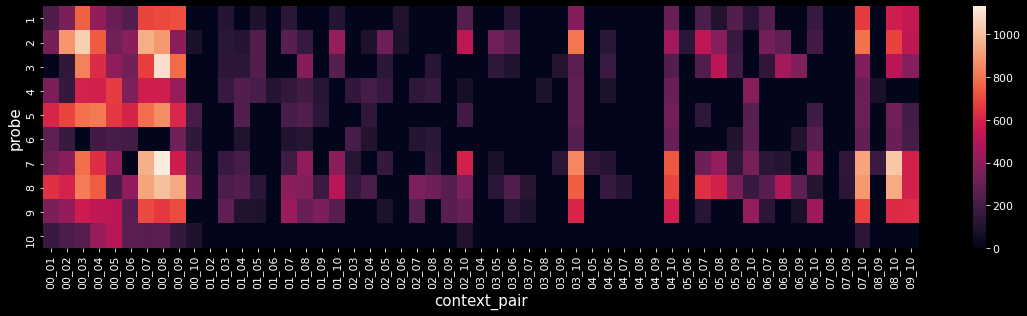

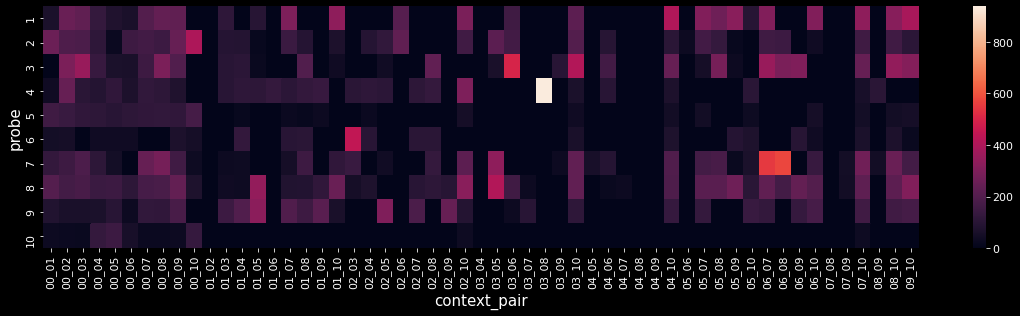

In [30]:
cell = 'TNC014a-22-1'
metrics = ["integral (d'*ms)", "center of mass (ms)"]

for metric in metrics:
    cell_barcode = summary.loc[[cell], [metric]].droplevel(level=0, axis=0).droplevel(level=0, axis=1)
    # display(cell_barcode)
    fig, ax = plt.subplots(figsize=(16,4.5))
    ax = sns.heatmap(data=cell_barcode, ax=ax)

    title = f'{cell} {metric} barcode'
    savefig(fig, 'NGP_retreat', title)

plt.show()

# site fingerprint
it displays all the neurons on the y axis and combinations of context-pairs_probes on the x axis

In [36]:
pivot_ready = full_long.loc[full_long.analysis == 'single cell',
                            ['region', 'id', 'trans_pair', 'context_pair', 'probe', 'metric', 'value']]
pivot_ready['site'] = pivot_ready.id.apply(lambda x: x[:7])


summary = pivot_ready.pivot_table(values='value', index=['region', 'site', 'id'],
                                  columns=['metric', 'probe', 'trans_pair', 'context_pair'], fill_value=np.nan)

summary.index = summary.index.droplevel(0)
display(summary)

metric               center of mass (ms)                                      \
probe                                 1                                        
trans_pair                     diff_diff                                       
context_pair                       02_03 02_04 02_05       02_06       02_07   
site    id                                                                     
TNC013a TNC013a-03-1            0.000000   0.0   0.0    0.000000    0.000000   
        TNC013a-03-3          431.491480   0.0   0.0    0.000000    0.000000   
        TNC013a-07-1            0.000000   0.0   0.0    0.000000    0.000000   
        TNC013a-10-1            0.000000   0.0   0.0    0.000000    0.000000   
        TNC013a-11-1            0.000000   0.0   0.0    0.000000    0.000000   
...                                  ...   ...   ...         ...         ...   
TNC018a TNC018a-43-1          195.492101   0.0   0.0    0.000000  281.786317   
        TNC018a-46-1            0.000000   0.0   0.0    0.000000    0.000000   
        TNC018a-48-1          199.388298   0.0   0.0  248.849172    0.000000   
        TNC018a-50-1            0.000000   0.0   0.0    0.000000    0.000000   
        TNC018a-54-1            0.000000   0.0   0.0    0.000000    0.000000   

metric                                                               ...  \
probe                                                                ...   
trans_pair                                                           ...   
context_pair               02_08       02_09      02_10 03_04 03_05  ...   
site    id                                                           ...   
TNC013a TNC013a-03-1    0.000000    0.000000   0.000000   0.0   0.0  ...   
        TNC013a-03-3    0.000000    0.000000   0.000000   0.0   0.0  ...   
        TNC013a-07-1    0.000000    0.000000   0.000000   0.0   0.0  ...   
        TNC013a-10-1    0.000000    0.000000   0.000000   0.0   0.0  ...   
        TNC013a-11-1    0.000000    0.000000   0.000000   0.0   0.0  ...   
...                          ...         ...        ...   ...   ...  ...   
TNC018a TNC018a-43-1  202.224459    0.000000  43.101099   0.0   0.0  ...   
        TNC018a-46-1    0.000000    0.000000   0.000000   0.0   0.0  ...   
        TNC018a-48-1  232.091913  195.168449   0.000000   0.0   0.0  ...   
        TNC018a-50-1    0.000000    0.000000   0.000000   0.0   0.0  ...   
        TNC018a-54-1    0.000000    0.000000   0.000000   0.0   0.0  ...   

metric               integral (d'*ms)                                          \
probe                              10                                           
trans_pair               silence_diff                                           
context_pair                    00_01      00_02      00_03 00_04 00_05 00_06   
site    id                                                                      
TNC013a TNC013a-03-1              0.0   0.000000   0.000000   0.0   0.0   0.0   
        TNC013a-03-3              0.0   0.000000   0.000000   0.0   0.0   0.0   
        TNC013a-07-1              0.0   0.000000   0.000000   0.0   0.0   0.0   
        TNC013a-10-1              0.0   0.000000   0.000000   0.0   0.0   0.0   
        TNC013a-11-1              0.0   0.000000   0.000000   0.0   0.0   0.0   
...                               ...        ...        ...   ...   ...   ...   
TNC018a TNC018a-43-1              0.0   0.000000   0.000000   0.0   0.0   0.0   
        TNC018a-46-1              0.0   0.000000   0.000000   0.0   0.0   0.0   
        TNC018a-48-1              0.0  56.036002  60.750878   0.0   0.0   0.0   
        TNC018a-50-1              0.0   0.000000   0.000000   0.0   0.0   0.0   
        TNC018a-54-1              0.0   0.000000   0.000000   0.0   0.0   0.0   

metric                                                     
probe                                                      
trans_pair                                   silence_same  
context_pair             

saving at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/TNC014a integral (d'*ms) barcode.png
saving at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/TNC014a center of mass (ms) barcode.png


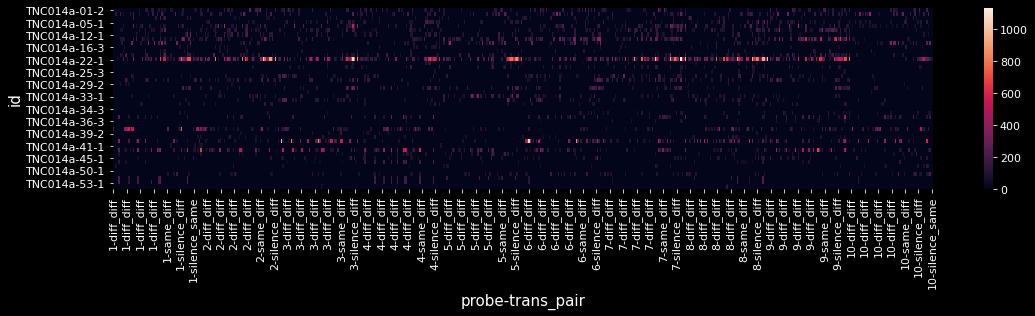

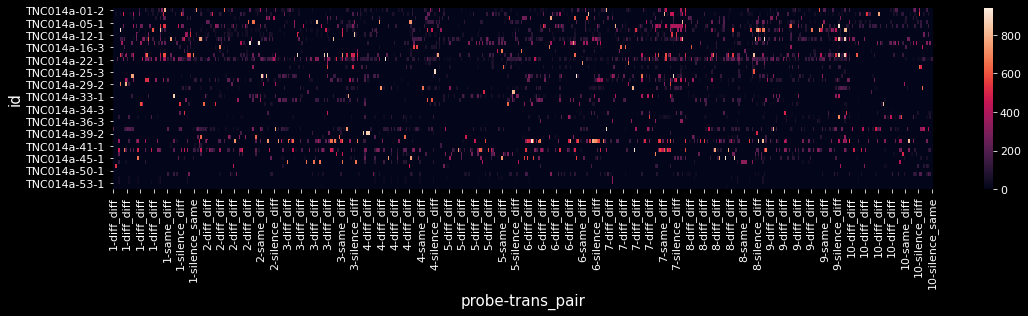

In [40]:
# sites = summary.index.unique(level=0).values
site = 'TNC014a'
metrics = ["integral (d'*ms)", "center of mass (ms)"]
for metric in metrics:
    site_barcode = summary.loc[[site], [metric]].droplevel(level=0, axis=0).droplevel(level=[0,3], axis=1)
    # site_barcode.columns = range(site_barcode.shape[1])
    fig, ax = plt.subplots(figsize=(16,4.5))
    ax = sns.heatmap(data=site_barcode, xticklabels='auto', ax=ax)
    title = f'{site} {metric} barcode'
    savefig(fig, 'NGP_retreat', title)
plt.show()
